## CSCI 5654 - Linear Programming - Project

***
#### Team Members
#### 1. Ketan Ramesh
#### 2. Shreyas Gopalakrishna
***

## Vehicle Routing Problem with Simultaneous Pickup and Delivery

In [1]:
!pip3 install pulp

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import random
import pulp
import gurobipy as gp
from gurobipy import GRB
from scipy.spatial import distance

## Vehicle Routing Problem with Simultaneous Pickup and Delivery (VRPSDP)
​
Paper Link - [Vehicle Routing Problem with Deliveries and Pickups: Modelling Issues and Meta-heuristics Solution Approaches](https://core.ac.uk/download/pdf/19477982.pdf)
​
<div align="justify">
The code provided below creates a <code>class</code> to frame and solve the Vehicle Routing Problem with Simultaneous Pickup and Delivery (VRPSDP) using the two-index flow formulation as mentioned in the paper. The formulation of the problem as a Mixed ILP is as follows:
</div>
​
$$
min \sum_{i=0}^{n} \sum_{j=0}^{n} d_{ij} x_{ij}
$$
​
$$
s.t. \sum_{i=0}^{n} x_{ij} = 1, j \in \{1, ..., n\}, - (3.1)
$$
​
$$
\sum_{i=0}^{n} x_{ji} = 1, j \in \{1, ..., n\}, - (3.2)
$$
​
$$
\sum_{i=0}^{n} R_{ij} - q_{j} = \sum_{i=0}^{n} R_{ji}, j \in \{1, ..., n\}, - (3.3)
$$
​
$$
\sum_{i=0}^{n} P_{ij} + b_{j} = \sum_{i=0}^{n} P_{ji}, j \in \{1, ..., n\}, - (3.4)
$$
​
$$
\sum_{i=1}^{n} R_{i0} = 0, - (3.5)
$$
​
$$
\sum_{i=1}^{n} P_{0i} = 0, - (3.6)
$$
​
$$
R_{ij} + P_{ij} \leq C x_{ij}, i, j \in \{0, ..., n\}, - (3.7)
$$
​
$$
x_{ij} = \{0, 1\}, i, j \in \{1, ... n\}
$$
​
$$
R_{ij}, P_{ij} \geq 0, i, j \in \{1, ..., n\}
$$
​
where,<br />
​
d<sub>ij</sub> = Cost to travel from node i to j.<br />
q<sub>i</sub> = The delivery demand of node i.<br />
b<sub>i</sub> = The pickup demand of node i.<br />
C = Vehicle capacity.<br />
​
<b>Decision Variables:</b><br />
1. x<sub>ij</sub> = {<b>1</b>, if edge (i, j) present in any route. <b>0</b>, otherwise}.<br />
2. R<sub>ij</sub> = The amount of delivery goods on board on arc ij.<br />
3. P<sub>ij</sub> = The amount of pickup goods on board on arc ij.<br />
​
<div align="justify">
The objective is to minimize the sum of the distances of all routes that satisfy the given constraints. The constraints (3.1) and (3.2) ensure that every node is visited exactly once (every node leads to only one other node, every node must be visited by only one other node). The constraints (3.3) and (3.4) ensure that the flow conservation is met (at a node <i>j</i>, the amount of delivery load after servicing delivery of node <i>j</i>, must be equal to pickup load at the same node. The pickup load condition is similar in nature). The constraints (3.5) and (3.6) ensure that the depot has zero pickup and delivery load. The constraint (3.7) ensures that the pickup and demand loads do not exceed the capacity of the vehicle at all nodes in the routes.  
</div>
​

In [84]:
class VRPSDP_GUROBI:
	def __init__(self, costMatrix, demand, pickup, numberOfVehicles, capacityOfVehicle):
		self.costMatrix = costMatrix
		self.n = len(costMatrix)
		self.demand = demand
		self.pickup = pickup
		self.numberOfVehicles = numberOfVehicles
		self.capacityOfVehicle = capacityOfVehicle
		self.initialzeLP()

	def initialzeLP(self):
		self.cvrpLP = gp.Model('VRP-SDP')
		x, R, P = [], [], []

		# Create decision variables
		for i in range(self.n):
			xRow, RRow, PRow = [], [], []
			for j in range(self.n):
				xRow.append(self.cvrpLP.addVar(name='x('+str(i)+","+str(j)+")", vtype=GRB.BINARY, lb=0, ub=1))
				RRow.append(self.cvrpLP.addVar(name='R('+str(i)+","+str(j)+")", vtype=GRB.INTEGER, lb=0))
				PRow.append(self.cvrpLP.addVar(name='P('+str(i)+","+str(j)+")", vtype=GRB.INTEGER, lb=0))
			x.append(xRow)
			R.append(RRow)
			P.append(PRow)

		# Create objective
		objective = None
		for i in range(self.n):
			for j in range(self.n):
				objective += self.costMatrix[i][j] * x[i][j]
		self.cvrpLP.setObjective(objective,GRB.MINIMIZE)

		# constraint 1
		for j in range(1, self.n):
			const1 = None
			for i in range(self.n):
				if(const1 == None):
					const1 = x[i][j]
				else:
					const1 = const1 + x[i][j]
			self.cvrpLP.addConstr(const1 == 1)
		
		# constraint 2
		for j in range(1, self.n):
			const2 = None
			for i in range(self.n):
				if(const2 == None):
					const2 = x[j][i]
				else:
					const2 = const2 + x[j][i]
			self.cvrpLP.addConstr(const2 == 1)

		# constraint 3
		for j in range(1, self.n):
			const3a, const3b = None, None
			for i in range(self.n):
				if(const3a == None):
					const3a = R[i][j]
				else:
					const3a = const3a + R[i][j]
				if(const3b == None):
					const3b = R[j][i]
				else:
					const3b = const3b + R[j][i]
			self.cvrpLP.addConstr(const3a - self.demand[j] == const3b)

		# constraint 4
		for j in range(1, self.n):
			const4a, const4b = None, None
			for i in range(self.n):
				if(const4a == None):
					const4a = P[i][j]
				else:
					const4a = const4a + P[i][j]
				if(const4b == None):
					const4b = P[j][i]
				else:
					const4b = const4b + P[j][i]
			self.cvrpLP.addConstr(const4a + self.pickup[j] == const4b)

		# constraint 5
		const5 = None
		for i in range(1, self.n):
			if(const5 == None):
				const5 = P[0][i]
			else:
				const5 = const5 + P[0][i]
		self.cvrpLP.addConstr(const5 == 0)

		# constraint 6
		const6 = None
		for i in range(1, self.n):
			if(const6 == None):
				const6 = R[i][0]
			else:
				const6 = const6 + R[i][0]
		self.cvrpLP.addConstr(const6 == 0)

		# constraint 7
		for i in range(self.n):
			for j in range(self.n):
				self.cvrpLP.addConstr(R[i][j] + P[i][j] <= self.capacityOfVehicle * x[i][j])

		# constraint 8
		for i in range(1, self.n):
			self.cvrpLP.addConstr(x[0][i] <= self.numberOfVehicles)

	def solve(self):
		status = self.cvrpLP.optimize()
		print(status)
	
	def getResult(self):
		print("Objective value: ", self.cvrpLP.ObjVal)
		for v in self.cvrpLP.getVars():
			print(v.varName, " = ", v.x)
		return self.cvrpLP

## E-N13-K4.vrp - Christofides and Eilon

In [109]:
costMatrix = [[0,9,14,23,32,50,21,49,30,27,35,28,18],   
[9,0,21,22,36,52,24,51,36,37,41,30,20],    
[14,21,0,25,38,5,31,7,36,43,29,7,6],    
[23,22,25,0,42,12,35,17,44,31,31,11,6],
[32,36,38,42,0,22,37,16,46,37,29,13,14],   
[50,52,5,12,22,0,41,23,10,39,9,17,16],   
[21,24,31,35,37,41,0,26,21,19,10,25,12],  
[49,51,7,17,16,23,26,0,30,28,16,27,12],   
[30,36,36,44,46,10,21,30,0,25,22,10,20],    
[27,37,43,31,37,39,19,28,25,0,20,16,8],   
[35,41,29,31,29,9,10,16,22,20,0,10,10],   
[28,30,7,11,13,17,25,27,10,16,10,0,10],
[18,20, 6, 6,14,16,12,12,20,8, 10,10,0]]

len(costMatrix)

13

In [110]:
demand = [0, 1200, 1700, 1500, 1400, 1700, 1400, 1200, 1900, 1800, 1600, 1700, 1100] 
pickup = [1100, 0, 1200, 1700, 1500, 1400, 1700, 1400, 1200, 1900, 1800, 1600, 1700]
capacityOfVehicle = 6000
numberOfVehicles = 4

In [111]:
lp2 = VRPSDP_GUROBI(costMatrix, demand, pickup, numberOfVehicles, capacityOfVehicle)
lp2.solve()
result = lp2.getResult()

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 231 rows, 507 columns and 1431 nonzeros
Model fingerprint: 0xb8164ab9
Variable types: 0 continuous, 507 integer (169 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [5e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 51 rows and 87 columns
Presolve time: 0.01s
Presolved: 180 rows, 420 columns, 1236 nonzeros
Variable types: 0 continuous, 420 integer (132 binary)
Found heuristic solution: objective 662.0000000

Root relaxation: objective 2.185667e+02, 354 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  218.56667    0   19  662.00000  218.56667  67.0%     -    0s
H    0     0                     436.0000000  218.56667  49.9%     -    0s
H    0     0                     414.0000000  218.566

In [112]:
# Use output to get path
# gets variables as (x,y) coordinates
variables = []
for v in result.getVars():
    if('x' in v.varName and v.x == 1):
        # print(v.name, " = ", v.varValue)
        temp = (v.varName.split('(')[1].split(')')[0].split(','))
        variables.append((int(temp[0]),int(temp[1])))
print(variables)

variablesR = {}
for v in result.getVars():
    if('R' in v.varName and v.x > 0):
        temp = (v.varName.split('(')[1].split(')')[0].split(','))
#         variablesR[((xCoordinates[int(temp[0])],yCoordinates[int(temp[0])]), (xCoordinates[int(temp[1])],yCoordinates[int(temp[1])]))] = round(v.x, 2)
        variablesR[(xCoordinates[int(temp[1])],yCoordinates[int(temp[1])])] = round(v.x, 2)
print("variablesR", variablesR)

variablesP = {}
for v in result.getVars():
    if('P' in v.varName and v.x > 0):
        # print(v.name, " = ", v.varValue)
        temp = (v.varName.split('(')[1].split(')')[0].split(','))
#         variablesP[((xCoordinates[int(temp[0])],yCoordinates[int(temp[0])]), (xCoordinates[int(temp[1])],yCoordinates[int(temp[1])]))] = round(v.x, 2)
        variablesP[(xCoordinates[int(temp[1])],yCoordinates[int(temp[1])])] = round(v.x, 2)
print("variablesP",variablesP)

#recursive calls for getting the path
def recursiveList(start, L, X, c):
    if(start in c):
        return X
    for item in L:
        if(item[0] == start):
            X.append(item)
            c.append(start)
            return recursiveList(item[1], L, X, c)
    return X

pathList = []
setList = []
start = 0
for v in variables:
    if(v[0] == start):
        path = recursiveList(v[1], variables, [v], [start])
        print(path)
        pathList.append(path)
        set1 = []
        for i in path:
            set1.append(i[0])
            set1.append(i[1])
        a = list(set(set1))
        if(len(a)>1):
            setList.append(sorted(a))
            
print(setList)

[(0, 0), (0, 1), (0, 2), (0, 6), (0, 8), (1, 3), (2, 7), (3, 12), (4, 11), (5, 10), (6, 0), (7, 4), (8, 5), (9, 0), (10, 0), (11, 0), (12, 9)]
variablesR {(151, 164): 5600.0, (159, 261): 6000.0, (146, 246): 1400.0, (142, 239): 5200.0, (130, 254): 4400.0, (161, 242): 4300.0, (156, 217): 2900.0, (128, 231): 1700.0, (148, 232): 1600.0, (128, 252): 3100.0, (163, 247): 3300.0, (163, 236): 1800.0}
variablesP {(161, 242): 1200.0, (156, 217): 1700.0, (128, 231): 4100.0, (148, 232): 2600.0, (145, 215): 5700.0, (128, 252): 2600.0, (163, 247): 1200.0, (163, 236): 3400.0}
[(0, 0)]
[(0, 1), (1, 3), (3, 12), (12, 9), (9, 0)]
[(0, 2), (2, 7), (7, 4), (4, 11), (11, 0)]
[(0, 6), (6, 0)]
[(0, 8), (8, 5), (5, 10), (10, 0)]
[[0, 1, 3, 9, 12], [0, 2, 4, 7, 11], [0, 6], [0, 5, 8, 10]]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/Users/shreyas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like

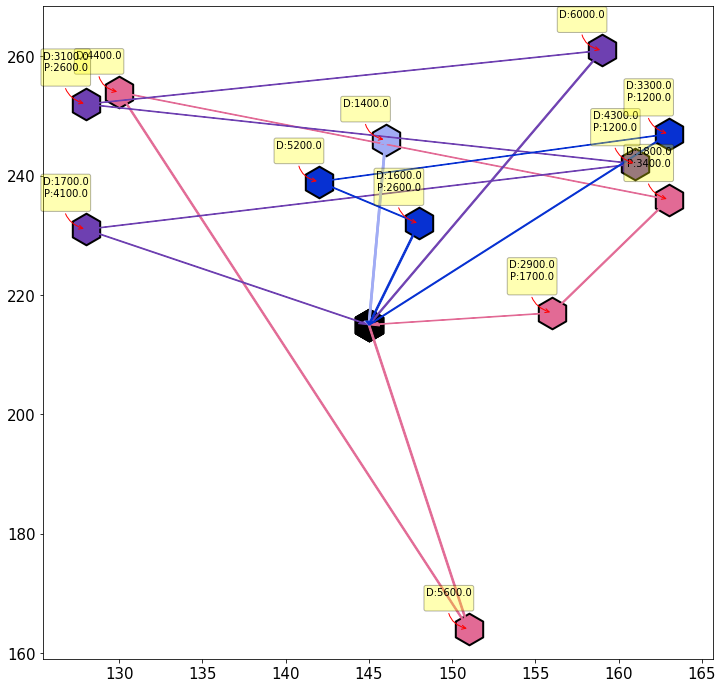

In [113]:
# Visualization
plt.figure(figsize=(12,12))
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

coordinateList = []
for s in setList:
    coordinate = []
    for j in s:
        coordinate.append([float(xCoordinates[j]), float(yCoordinates[j])])
    coordinateList.append(coordinate)
# print(coordinateList)

def addToPlot(L):
    x_val = [x[0] for x in L]
    y_val = [x[1] for x in L]

    r = random.random()
    b = random.random()
    g = random.random()
    newColor = (r, g, b)
    
    plt.scatter(x_val,y_val, c=newColor, edgecolor='black', linewidth=2, s=1000, marker='h')
    ax = plt.axes()
    
    length = len(L)-1
    
    for i in range(length):
        ax.arrow(L[i][0],  #x1
                    L[i][1],  # y1
                    L[i+1][0]-L[i][0], # x2 - x1
                    L[i+1][1]-L[i][1], # y2 - y1
                    width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
                    )
        aS = ""
        if((int(L[i+1][0]),int(L[i+1][1]))) in variablesR:
            aS += "D:" + str(variablesR[(int(L[i+1][0]),int(L[i+1][1]))]) + "\n"
        if((int(L[i+1][0]),int(L[i+1][1]))) in variablesP:
            aS += "P:" + str(variablesP[(int(L[i+1][0]),int(L[i+1][1]))]) + "\n"
        
        ax.annotate(aS, xy=(L[i+1][0], L[i+1][1]), xytext=(-20,20), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='red'))
    
    ax.arrow(L[-1][0],  #x1
                    L[-1][1],  # y1
                    L[0][0]-L[-1][0], # x2 - x1
                    L[0][1]-L[-1][1], # y2 - y1
                    width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
                    )
for i in range(len(coordinateList)):
#     print(coordinateList[i])
    addToPlot(coordinateList[i])
plt.scatter(coordinateList[0][0][0],coordinateList[0][0][1], c='black', edgecolor='black', linewidth='2', s=1000, marker='h')
plt.show()

## E-N22-K4.vrp - Christofides and Eilon

In [94]:
# E-n22-k4.vrp = CE22P

xCoordinates = [145, 151, 159, 130, 128, 163, 146, 161, 142, 163, 148, 128, 156, 129, 146, 164, 141, 147, 164, 129, 155, 139]
yCoordinates = [215, 164, 261, 254, 252, 247, 246, 242, 239, 236, 232, 231, 217, 214, 208, 208, 206, 193, 193, 189, 185, 182]

costMatrix = np.ndarray(shape=(len(xCoordinates), len(yCoordinates)))
for i in range(len(xCoordinates)):
    for j in range(len(yCoordinates)):
        costMatrix[i][j] = float(distance.euclidean([xCoordinates[i],yCoordinates[i]], [xCoordinates[j],yCoordinates[j]]))

demand = [0, 1100, 700, 800, 1400, 2100, 400, 800, 100, 500, 600, 1200, 1300, 1300, 300, 900, 2100, 1000, 900, 2100, 1000, 900, 2500, 700]
pickup = [700, 0, 1100, 700, 800, 1400, 2100, 400, 800, 100, 500, 600, 1200, 1300, 1300, 300, 900, 2100, 1000, 900, 2100, 1000, 900, 2500]
capacityOfVehicle = 6000
numberOfVehicles = 7

In [95]:
lp = VRPSDP_GUROBI(costMatrix, demand, pickup, numberOfVehicles, capacityOfVehicle)

In [96]:
lp.solve()
result = lp.getResult()

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 591 rows, 1452 columns and 4203 nonzeros
Model fingerprint: 0x75260d28
Variable types: 0 continuous, 1452 integer (484 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 87 rows and 150 columns
Presolve time: 0.09s
Presolved: 504 rows, 1302 columns, 3864 nonzeros
Variable types: 0 continuous, 1302 integer (420 binary)
Found heuristic solution: objective 1106.2205425

Root relaxation: objective 3.343201e+02, 1078 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  334.32013    0   44 1106.22054  334.32013  69.8%     -    0s
H    0     0                     531.7909921  334.32013  37.1%     -    0s
H    0     0                     516.7753354  

P(7,6)  =  0.0
x(7,7)  =  0.0
R(7,7)  =  0.0
P(7,7)  =  0.0
x(7,8)  =  0.0
R(7,8)  =  0.0
P(7,8)  =  0.0
x(7,9)  =  0.0
R(7,9)  =  0.0
P(7,9)  =  0.0
x(7,10)  =  0.0
R(7,10)  =  0.0
P(7,10)  =  0.0
x(7,11)  =  0.0
R(7,11)  =  0.0
P(7,11)  =  0.0
x(7,12)  =  0.0
R(7,12)  =  0.0
P(7,12)  =  0.0
x(7,13)  =  0.0
R(7,13)  =  0.0
P(7,13)  =  0.0
x(7,14)  =  0.0
R(7,14)  =  0.0
P(7,14)  =  0.0
x(7,15)  =  0.0
R(7,15)  =  0.0
P(7,15)  =  0.0
x(7,16)  =  0.0
R(7,16)  =  0.0
P(7,16)  =  0.0
x(7,17)  =  0.0
R(7,17)  =  0.0
P(7,17)  =  0.0
x(7,18)  =  0.0
R(7,18)  =  0.0
P(7,18)  =  0.0
x(7,19)  =  0.0
R(7,19)  =  0.0
P(7,19)  =  0.0
x(7,20)  =  0.0
R(7,20)  =  0.0
P(7,20)  =  0.0
x(7,21)  =  0.0
R(7,21)  =  0.0
P(7,21)  =  0.0
x(8,0)  =  1.0
R(8,0)  =  0.0
P(8,0)  =  4200.0
x(8,1)  =  0.0
R(8,1)  =  0.0
P(8,1)  =  0.0
x(8,2)  =  0.0
R(8,2)  =  0.0
P(8,2)  =  0.0
x(8,3)  =  0.0
R(8,3)  =  0.0
P(8,3)  =  0.0
x(8,4)  =  0.0
R(8,4)  =  0.0
P(8,4)  =  0.0
x(8,5)  =  0.0
R(8,5)  =  0.0
P(8,5)  =  0.0
x

In [102]:
# Use output to get path
# gets variables as (x,y) coordinates
variables = []
for v in result.getVars():
    if('x' in v.varName and v.x == 1):
        # print(v.name, " = ", v.varValue)
        temp = (v.varName.split('(')[1].split(')')[0].split(','))
        variables.append((int(temp[0]),int(temp[1])))
print(variables)

variablesR = {}
for v in result.getVars():
    if('R' in v.varName and v.x > 0):
        temp = (v.varName.split('(')[1].split(')')[0].split(','))
#         variablesR[((xCoordinates[int(temp[0])],yCoordinates[int(temp[0])]), (xCoordinates[int(temp[1])],yCoordinates[int(temp[1])]))] = round(v.x, 2)
        variablesR[(xCoordinates[int(temp[1])],yCoordinates[int(temp[1])])] = round(v.x, 2)
print("variablesR", variablesR)

variablesP = {}
for v in result.getVars():
    if('P' in v.varName and v.x > 0):
        # print(v.name, " = ", v.varValue)
        temp = (v.varName.split('(')[1].split(')')[0].split(','))
#         variablesP[((xCoordinates[int(temp[0])],yCoordinates[int(temp[0])]), (xCoordinates[int(temp[1])],yCoordinates[int(temp[1])]))] = round(v.x, 2)
        variablesP[(xCoordinates[int(temp[1])],yCoordinates[int(temp[1])])] = round(v.x, 2)
print("variablesP",variablesP)

#recursive calls for getting the path
def recursiveList(start, L, X, c):
    if(start in c):
        return X
    for item in L:
        if(item[0] == start):
            X.append(item)
            c.append(start)
            return recursiveList(item[1], L, X, c)
    return X

pathList = []
setList = []
start = 0
for v in variables:
    if(v[0] == start):
        path = recursiveList(v[1], variables, [v], [start])
        print(path)
        pathList.append(path)
        set1 = []
        for i in path:
            set1.append(i[0])
            set1.append(i[1])
        a = list(set(set1))
        if(len(a)>1):
            setList.append(sorted(a))
            
print(setList)

[(0, 0), (0, 9), (0, 12), (0, 13), (0, 19), (1, 20), (2, 6), (3, 8), (4, 3), (5, 2), (6, 10), (7, 5), (8, 0), (9, 7), (10, 0), (11, 4), (12, 15), (13, 11), (14, 0), (15, 17), (16, 14), (17, 16), (18, 0), (19, 21), (20, 18), (21, 1)]
variablesR {(163, 236): 5100.0, (156, 217): 5600.0, (129, 214): 4800.0, (129, 189): 6000.0, (155, 185): 1900.0, (146, 246): 1000.0, (142, 239): 100.0, (130, 254): 900.0, (159, 261): 1700.0, (148, 232): 600.0, (163, 247): 3800.0, (161, 242): 4600.0, (128, 252): 2300.0, (164, 208): 4300.0, (128, 231): 3500.0, (147, 193): 3400.0, (146, 208): 300.0, (141, 206): 2400.0, (139, 182): 3900.0, (164, 193): 900.0, (151, 164): 3000.0}
variablesP {(155, 185): 1900.0, (146, 246): 3000.0, (142, 239): 3400.0, (130, 254): 2700.0, (159, 261): 1900.0, (148, 232): 5100.0, (163, 247): 500.0, (145, 215): 5000.0, (161, 242): 100.0, (128, 252): 1900.0, (164, 208): 1200.0, (128, 231): 1300.0, (147, 193): 1500.0, (146, 208): 4500.0, (141, 206): 3600.0, (139, 182): 900.0, (164, 193):

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/Users/shreyas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like

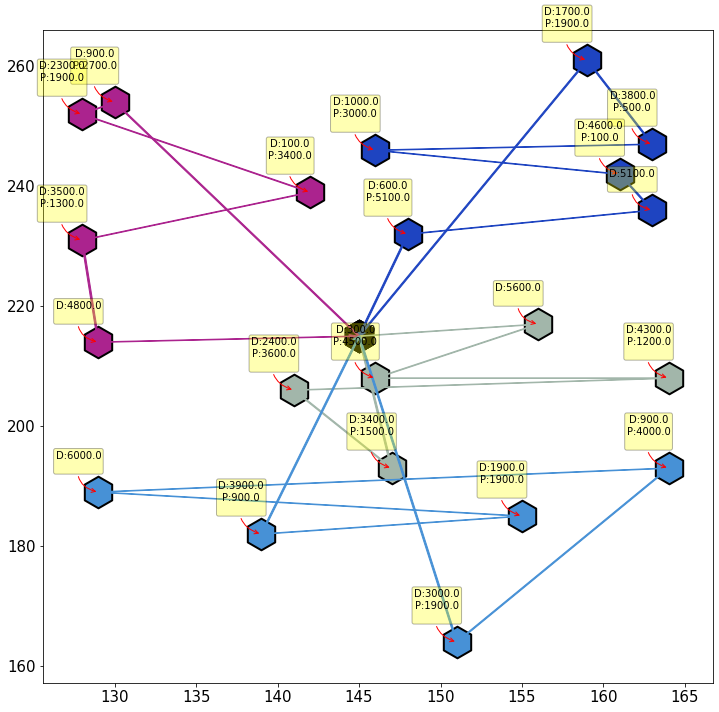

In [107]:
# Visualization
plt.figure(figsize=(12,12))
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

coordinateList = []
for s in setList:
    coordinate = []
    for j in s:
        coordinate.append([float(xCoordinates[j]), float(yCoordinates[j])])
    coordinateList.append(coordinate)
# print(coordinateList)

def addToPlot(L):
    x_val = [x[0] for x in L]
    y_val = [x[1] for x in L]

    r = random.random()
    b = random.random()
    g = random.random()
    newColor = (r, g, b)
    
    plt.scatter(x_val,y_val, c=newColor, edgecolor='black', linewidth=2, s=1000, marker='h')
    ax = plt.axes()
    
    length = len(L)-1
    
    for i in range(length):
        ax.arrow(L[i][0],  #x1
                    L[i][1],  # y1
                    L[i+1][0]-L[i][0], # x2 - x1
                    L[i+1][1]-L[i][1], # y2 - y1
                    width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
                    )
        aS = ""
        if((int(L[i+1][0]),int(L[i+1][1]))) in variablesR:
            aS += "D:" + str(variablesR[(int(L[i+1][0]),int(L[i+1][1]))]) + "\n"
        if((int(L[i+1][0]),int(L[i+1][1]))) in variablesP:
            aS += "P:" + str(variablesP[(int(L[i+1][0]),int(L[i+1][1]))]) + "\n"
        
        ax.annotate(aS, xy=(L[i+1][0], L[i+1][1]), xytext=(-20,20), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='red'))
    
    ax.arrow(L[-1][0],  #x1
                    L[-1][1],  # y1
                    L[0][0]-L[-1][0], # x2 - x1
                    L[0][1]-L[-1][1], # y2 - y1
                    width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
                    )
for i in range(len(coordinateList)):
#     print(coordinateList[i])
    addToPlot(coordinateList[i])
plt.scatter(coordinateList[0][0][0],coordinateList[0][0][1], c='black', edgecolor='black', linewidth='2', s=1000, marker='h')
plt.show()

## E-N30-K4.vrp - Christofides and Eilon

In [118]:
xCoordinates = [162, 218, 218, 201, 214, 224, 210, 104, 126, 119, 129, 126, 125, 116, 126, 125, 119, 115, 153, 175, 180, 159, 188, 152, 215, 212, 188, 207, 184, 207]
yCoordinates = [354, 382, 358, 370, 371, 370, 382, 354, 338, 340, 349, 347, 346, 355, 335, 355, 357, 341, 351, 363, 360, 331, 357, 349, 389, 394, 393, 406, 410, 392]

costMatrix = np.ndarray(shape=(len(xCoordinates), len(yCoordinates)))
for i in range(len(xCoordinates)):
    for j in range(len(yCoordinates)):
        costMatrix[i][j] = float(distance.euclidean([xCoordinates[i],yCoordinates[i]], [xCoordinates[j],yCoordinates[j]]))

demand = [0, 300, 3100, 125, 100, 200, 150, 150, 450, 300, 100, 950, 125, 150, 150, 550, 150, 100, 150, 400, 300, 1500, 100, 300, 500, 800, 300, 100, 150, 1000]
pickup = [1000, 0, 300, 3100, 125, 100, 200, 150, 150, 450, 300, 100, 950, 125, 150, 150, 550, 150, 100, 150, 400, 300, 1500, 100, 300, 500, 800, 300, 100, 150]
capacityOfVehicle = 4500
numberOfVehicles = 4




In [119]:
lp = VRPSDP_GUROBI(costMatrix, demand, pickup, numberOfVehicles, capacityOfVehicle)
lp.solve()
result = lp.getResult()

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 1047 rows, 2700 columns and 7891 nonzeros
Model fingerprint: 0xf3fe0944
Variable types: 0 continuous, 2700 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+03]
Presolve removed 122 rows and 215 columns
Presolve time: 0.04s
Presolved: 925 rows, 2485 columns, 7397 nonzeros
Variable types: 0 continuous, 2485 integer (809 binary)
Found heuristic solution: objective 2536.8168000

Root relaxation: objective 4.248668e+02, 2861 iterations, 0.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  424.86683    0   70 2536.81680  424.86683  83.3%     -    0s
H    0     0                     582.2013669  424.86683  27.0%     -    0s
H    0     0                     579.9179075

 134235 38212  503.57678   68   81  510.19047  497.18449  2.55%  79.7  141s
 139992 39546  503.14836   27  189  510.19047  497.37482  2.51%  79.1  145s
 147300 40910  508.12887   74   41  510.19047  497.60700  2.47%  78.2  150s
 155656 42510  500.86503   61  110  510.19047  497.87822  2.41%  77.2  155s
 162739 43872  507.98312   77   16  510.19047  498.07249  2.38%  76.5  160s
 169536 44990  509.45482   48  120  510.19047  498.24731  2.34%  75.8  165s
 176198 46159  502.74328   68   54  510.19047  498.42147  2.31%  75.2  170s
 181707 47003  502.76418   72   63  510.19047  498.55525  2.28%  74.7  175s
 186198 47839     cutoff   71       510.19047  498.65845  2.26%  74.3  180s
 192413 48762  506.75050   58  123  510.19047  498.80170  2.23%  73.8  185s
 199637 50024  501.72345   66   89  510.19047  498.96346  2.20%  73.2  190s
 205466 51030     cutoff   56       510.19047  499.09354  2.18%  72.7  195s
 212746 52100  499.47326   72   94  510.19047  499.24590  2.15%  72.1  200s
 220213 5305


Optimal solution found (tolerance 1.00e-04)
Best objective 5.101904657305e+02, best bound 5.101904657305e+02, gap 0.0000%
None
Objective value:  510.1904657304714
x(0,0)  =  1.0
R(0,0)  =  0.0
P(0,0)  =  0.0
x(0,1)  =  0.0
R(0,1)  =  0.0
P(0,1)  =  0.0
x(0,2)  =  0.0
R(0,2)  =  0.0
P(0,2)  =  0.0
x(0,3)  =  0.0
R(0,3)  =  0.0
P(0,3)  =  0.0
x(0,4)  =  0.0
R(0,4)  =  0.0
P(0,4)  =  0.0
x(0,5)  =  0.0
R(0,5)  =  0.0
P(0,5)  =  0.0
x(0,6)  =  0.0
R(0,6)  =  0.0
P(0,6)  =  0.0
x(0,7)  =  0.0
R(0,7)  =  0.0
P(0,7)  =  0.0
x(0,8)  =  0.0
R(0,8)  =  0.0
P(0,8)  =  0.0
x(0,9)  =  0.0
R(0,9)  =  0.0
P(0,9)  =  0.0
x(0,10)  =  0.0
R(0,10)  =  0.0
P(0,10)  =  0.0
x(0,11)  =  0.0
R(0,11)  =  0.0
P(0,11)  =  0.0
x(0,12)  =  0.0
R(0,12)  =  0.0
P(0,12)  =  0.0
x(0,13)  =  0.0
R(0,13)  =  0.0
P(0,13)  =  0.0
x(0,14)  =  0.0
R(0,14)  =  0.0
P(0,14)  =  0.0
x(0,15)  =  1.0
R(0,15)  =  3625.0
P(0,15)  =  0.0
x(0,16)  =  0.0
R(0,16)  =  0.0
P(0,16)  =  0.0
x(0,17)  =  0.0
R(0,17)  =  0.0
P(0,17)  =  0.0

x(10,13)  =  0.0
R(10,13)  =  0.0
P(10,13)  =  0.0
x(10,14)  =  0.0
R(10,14)  =  0.0
P(10,14)  =  0.0
x(10,15)  =  0.0
R(10,15)  =  0.0
P(10,15)  =  0.0
x(10,16)  =  0.0
R(10,16)  =  0.0
P(10,16)  =  0.0
x(10,17)  =  0.0
R(10,17)  =  0.0
P(10,17)  =  0.0
x(10,18)  =  0.0
R(10,18)  =  0.0
P(10,18)  =  0.0
x(10,19)  =  0.0
R(10,19)  =  0.0
P(10,19)  =  0.0
x(10,20)  =  0.0
R(10,20)  =  0.0
P(10,20)  =  0.0
x(10,21)  =  0.0
R(10,21)  =  0.0
P(10,21)  =  0.0
x(10,22)  =  0.0
R(10,22)  =  0.0
P(10,22)  =  0.0
x(10,23)  =  1.0
R(10,23)  =  450.0
P(10,23)  =  3225.0
x(10,24)  =  0.0
R(10,24)  =  0.0
P(10,24)  =  0.0
x(10,25)  =  0.0
R(10,25)  =  0.0
P(10,25)  =  0.0
x(10,26)  =  0.0
R(10,26)  =  0.0
P(10,26)  =  0.0
x(10,27)  =  0.0
R(10,27)  =  0.0
P(10,27)  =  0.0
x(10,28)  =  0.0
R(10,28)  =  0.0
P(10,28)  =  0.0
x(10,29)  =  0.0
R(10,29)  =  0.0
P(10,29)  =  0.0
x(11,0)  =  0.0
R(11,0)  =  0.0
P(11,0)  =  0.0
x(11,1)  =  0.0
R(11,1)  =  0.0
P(11,1)  =  0.0
x(11,2)  =  0.0
R(11,2)  =  0.0


P(15,29)  =  0.0
x(16,0)  =  0.0
R(16,0)  =  0.0
P(16,0)  =  0.0
x(16,1)  =  0.0
R(16,1)  =  0.0
P(16,1)  =  0.0
x(16,2)  =  0.0
R(16,2)  =  0.0
P(16,2)  =  0.0
x(16,3)  =  0.0
R(16,3)  =  0.0
P(16,3)  =  0.0
x(16,4)  =  0.0
R(16,4)  =  0.0
P(16,4)  =  0.0
x(16,5)  =  0.0
R(16,5)  =  0.0
P(16,5)  =  0.0
x(16,6)  =  0.0
R(16,6)  =  0.0
P(16,6)  =  0.0
x(16,7)  =  0.0
R(16,7)  =  0.0
P(16,7)  =  0.0
x(16,8)  =  0.0
R(16,8)  =  0.0
P(16,8)  =  0.0
x(16,9)  =  0.0
R(16,9)  =  0.0
P(16,9)  =  0.0
x(16,10)  =  0.0
R(16,10)  =  0.0
P(16,10)  =  0.0
x(16,11)  =  0.0
R(16,11)  =  0.0
P(16,11)  =  0.0
x(16,12)  =  0.0
R(16,12)  =  0.0
P(16,12)  =  0.0
x(16,13)  =  1.0
R(16,13)  =  2925.0
P(16,13)  =  700.0
x(16,14)  =  0.0
R(16,14)  =  0.0
P(16,14)  =  0.0
x(16,15)  =  0.0
R(16,15)  =  0.0
P(16,15)  =  0.0
x(16,16)  =  0.0
R(16,16)  =  0.0
P(16,16)  =  0.0
x(16,17)  =  0.0
R(16,17)  =  0.0
P(16,17)  =  0.0
x(16,18)  =  0.0
R(16,18)  =  0.0
P(16,18)  =  0.0
x(16,19)  =  0.0
R(16,19)  =  0.0
P(16,

R(21,16)  =  0.0
P(21,16)  =  0.0
x(21,17)  =  0.0
R(21,17)  =  0.0
P(21,17)  =  0.0
x(21,18)  =  0.0
R(21,18)  =  0.0
P(21,18)  =  0.0
x(21,19)  =  0.0
R(21,19)  =  0.0
P(21,19)  =  0.0
x(21,20)  =  0.0
R(21,20)  =  0.0
P(21,20)  =  0.0
x(21,21)  =  0.0
R(21,21)  =  0.0
P(21,21)  =  0.0
x(21,22)  =  0.0
R(21,22)  =  0.0
P(21,22)  =  0.0
x(21,23)  =  0.0
R(21,23)  =  0.0
P(21,23)  =  0.0
x(21,24)  =  0.0
R(21,24)  =  0.0
P(21,24)  =  0.0
x(21,25)  =  0.0
R(21,25)  =  0.0
P(21,25)  =  0.0
x(21,26)  =  0.0
R(21,26)  =  0.0
P(21,26)  =  0.0
x(21,27)  =  0.0
R(21,27)  =  0.0
P(21,27)  =  0.0
x(21,28)  =  0.0
R(21,28)  =  0.0
P(21,28)  =  0.0
x(21,29)  =  0.0
R(21,29)  =  0.0
P(21,29)  =  0.0
x(22,0)  =  1.0
R(22,0)  =  0.0
P(22,0)  =  3850.0
x(22,1)  =  0.0
R(22,1)  =  0.0
P(22,1)  =  0.0
x(22,2)  =  0.0
R(22,2)  =  0.0
P(22,2)  =  0.0
x(22,3)  =  0.0
R(22,3)  =  0.0
P(22,3)  =  0.0
x(22,4)  =  0.0
R(22,4)  =  0.0
P(22,4)  =  0.0
x(22,5)  =  0.0
R(22,5)  =  0.0
P(22,5)  =  0.0
x(22,6)  =  

x(27,3)  =  0.0
R(27,3)  =  0.0
P(27,3)  =  0.0
x(27,4)  =  0.0
R(27,4)  =  0.0
P(27,4)  =  0.0
x(27,5)  =  0.0
R(27,5)  =  0.0
P(27,5)  =  0.0
x(27,6)  =  0.0
R(27,6)  =  0.0
P(27,6)  =  0.0
x(27,7)  =  0.0
R(27,7)  =  0.0
P(27,7)  =  0.0
x(27,8)  =  0.0
R(27,8)  =  0.0
P(27,8)  =  0.0
x(27,9)  =  0.0
R(27,9)  =  0.0
P(27,9)  =  0.0
x(27,10)  =  0.0
R(27,10)  =  0.0
P(27,10)  =  0.0
x(27,11)  =  0.0
R(27,11)  =  0.0
P(27,11)  =  0.0
x(27,12)  =  0.0
R(27,12)  =  0.0
P(27,12)  =  0.0
x(27,13)  =  0.0
R(27,13)  =  0.0
P(27,13)  =  0.0
x(27,14)  =  0.0
R(27,14)  =  0.0
P(27,14)  =  0.0
x(27,15)  =  0.0
R(27,15)  =  0.0
P(27,15)  =  0.0
x(27,16)  =  0.0
R(27,16)  =  0.0
P(27,16)  =  0.0
x(27,17)  =  0.0
R(27,17)  =  0.0
P(27,17)  =  0.0
x(27,18)  =  0.0
R(27,18)  =  0.0
P(27,18)  =  0.0
x(27,19)  =  0.0
R(27,19)  =  0.0
P(27,19)  =  0.0
x(27,20)  =  0.0
R(27,20)  =  0.0
P(27,20)  =  0.0
x(27,21)  =  0.0
R(27,21)  =  0.0
P(27,21)  =  0.0
x(27,22)  =  0.0
R(27,22)  =  0.0
P(27,22)  =  0.0
x

In [120]:
# Use output to get path
# gets variables as (x,y) coordinates
variables = []
for v in result.getVars():
    if('x' in v.varName and v.x == 1):
        # print(v.name, " = ", v.varValue)
        temp = (v.varName.split('(')[1].split(')')[0].split(','))
        variables.append((int(temp[0]),int(temp[1])))
print(variables)

variablesR = {}
for v in result.getVars():
    if('R' in v.varName and v.x > 0):
        temp = (v.varName.split('(')[1].split(')')[0].split(','))
#         variablesR[((xCoordinates[int(temp[0])],yCoordinates[int(temp[0])]), (xCoordinates[int(temp[1])],yCoordinates[int(temp[1])]))] = round(v.x, 2)
        variablesR[(xCoordinates[int(temp[1])],yCoordinates[int(temp[1])])] = round(v.x, 2)
print("variablesR", variablesR)

variablesP = {}
for v in result.getVars():
    if('P' in v.varName and v.x > 0):
        # print(v.name, " = ", v.varValue)
        temp = (v.varName.split('(')[1].split(')')[0].split(','))
#         variablesP[((xCoordinates[int(temp[0])],yCoordinates[int(temp[0])]), (xCoordinates[int(temp[1])],yCoordinates[int(temp[1])]))] = round(v.x, 2)
        variablesP[(xCoordinates[int(temp[1])],yCoordinates[int(temp[1])])] = round(v.x, 2)
print("variablesP",variablesP)

#recursive calls for getting the path
def recursiveList(start, L, X, c):
    if(start in c):
        return X
    for item in L:
        if(item[0] == start):
            X.append(item)
            c.append(start)
            return recursiveList(item[1], L, X, c)
    return X

pathList = []
setList = []
start = 0
for v in variables:
    if(v[0] == start):
        path = recursiveList(v[1], variables, [v], [start])
        print(path)
        pathList.append(path)
        set1 = []
        for i in path:
            set1.append(i[0])
            set1.append(i[1])
        a = list(set(set1))
        if(len(a)>1):
            setList.append(sorted(a))
            
print(setList)

[(0, 0), (0, 15), (0, 20), (0, 21), (0, 26), (1, 6), (2, 5), (3, 19), (4, 3), (5, 4), (6, 22), (7, 17), (8, 12), (9, 14), (10, 23), (11, 10), (12, 11), (13, 7), (14, 8), (15, 16), (16, 13), (17, 9), (18, 0), (19, 0), (20, 2), (21, 0), (22, 0), (23, 18), (24, 1), (25, 24), (26, 28), (27, 29), (28, 27), (29, 25)]
variablesR {(125, 355): 3625.0, (180, 360): 4225.0, (159, 331): 1500.0, (188, 393): 3400.0, (210, 382): 250.0, (224, 370): 825.0, (175, 363): 400.0, (201, 370): 525.0, (214, 371): 625.0, (188, 357): 100.0, (115, 341): 2625.0, (125, 346): 1625.0, (126, 335): 2225.0, (152, 349): 450.0, (129, 349): 550.0, (126, 347): 1500.0, (104, 354): 2775.0, (126, 338): 2075.0, (119, 357): 3075.0, (116, 355): 2925.0, (119, 340): 2525.0, (218, 358): 3925.0, (153, 351): 150.0, (218, 382): 550.0, (215, 389): 1050.0, (184, 410): 3100.0, (207, 392): 2850.0, (207, 406): 2950.0, (212, 394): 1850.0}
variablesP {(210, 382): 2150.0, (224, 370): 700.0, (175, 363): 4025.0, (201, 370): 925.0, (214, 371): 800

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/Users/shreyas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like

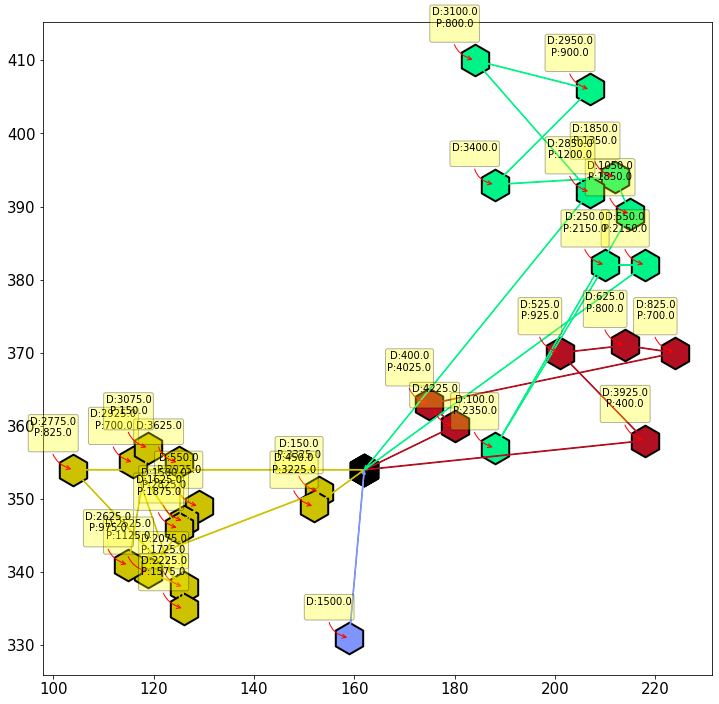

In [124]:
# Visualization
plt.figure(figsize=(12,12))
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

coordinateList = []
for s in setList:
    coordinate = []
    for j in s:
        coordinate.append([float(xCoordinates[j]), float(yCoordinates[j])])
    coordinateList.append(coordinate)
# print(coordinateList)

def addToPlot(L):
    x_val = [x[0] for x in L]
    y_val = [x[1] for x in L]

    r = random.random()
    b = random.random()
    g = random.random()
    newColor = (r, g, b)
    
    plt.scatter(x_val,y_val, c=newColor, edgecolor='black', linewidth=2, s=1000, marker='h')
    ax = plt.axes()
    
    length = len(L)-1
    
    for i in range(length):
        ax.arrow(L[i][0],  #x1
                    L[i][1],  # y1
                    L[i+1][0]-L[i][0], # x2 - x1
                    L[i+1][1]-L[i][1], # y2 - y1
                    width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
                    )
        aS = ""
        if((int(L[i+1][0]),int(L[i+1][1]))) in variablesR:
            aS += "D:" + str(variablesR[(int(L[i+1][0]),int(L[i+1][1]))]) + "\n"
        if((int(L[i+1][0]),int(L[i+1][1]))) in variablesP:
            aS += "P:" + str(variablesP[(int(L[i+1][0]),int(L[i+1][1]))]) + "\n"
        
        ax.annotate(aS, xy=(L[i+1][0], L[i+1][1]), xytext=(-20,20), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='red'))
    
    ax.arrow(L[-1][0],  #x1
                    L[-1][1],  # y1
                    L[0][0]-L[-1][0], # x2 - x1
                    L[0][1]-L[-1][1], # y2 - y1
                    width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
                    )
for i in range(len(coordinateList)):
#     print(coordinateList[i])
    addToPlot(coordinateList[i])
plt.scatter(coordinateList[0][0][0],coordinateList[0][0][1], c='black', edgecolor='black', linewidth='2', s=1000, marker='h')
plt.show()